<img src="../../../docs/images/DSPy8.png" alt="DSPy7 Image" height="150"/>

# Using __<ins>M</ins>ulti-stage <ins>I</ins>nstruction <ins>P</ins>roposal & <ins>O</ins>ptimization (MIPROv2)__ in DSPy
[![colab-badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stanfordnlp/dspy/blob/main/examples/qa/hotpot/hotpotqa_with_MIPRO.ipynb)

### FAQ 🙋
#### 1) How does MIPRO work?
At a high level, the MIPRO program optimizer works by first __proposing__ candidate fewshot example sets and instructions for each prompt in your program, and then __optimizing__ over these fewshot example sets and instructions as hyperparameters for a specified number of batches. Each batch, the optimizer evaluates different combinations of prompts on a subset of training inputs, which allows it to learn which combinations yield the best performance.

#### 2) How much will MIPRO cost me to run?
Note that __this notebook__ is free to run, because all LM calls have been cached. However, when using an optimizer on your own program, here is a breakdown of the upper bound of the number of calls to the task model and prompt model respectively:

- **Task model calls**: MIPRO makes up to __O(TxPxM)__ task model calls if you run without minibatching, where T is the number of batches, P is the number of prompts in the program, and M is the size of the train set. This is because the model is evaluating the program on the train set each batch.  If you run **with minibatching** you can reduce calls even further to __O(TxPxB)__ where **B** is the minibatch size.  Note that every few steps (a parameter you set) MIPRO will also run a full eval over all **M** examples.

- **Prompt model calls**: MIPRO makes up to N*P+10+(P+1) prompt model calls, where N is the number of instruction / fewshot example set candidates to generate for each prompt, and P is the number of prompts in the program. The extra 10 calls comes from generating a summary of the data in the training set, which we use in the meta prompt to create better instructions.  The extra (P+1) comes from program summarization where the proposer LLM will look at the program code and try to describe what each module does and what the whole program does.

#### 3) How should I configure the hyperparameters?
We have yet to run full hyperparameter sweeps with MIPRO, but based off of initial experimintation, we'd recommend the following:
- __Batch num__: Gains can be seen after about 20-30 batches. However, 100-200 batches can help with adding on additional marginal gains.
- __num candidates__: This hyperparameter controls the number of candidate prompts and fewshot example sets that are generated to optimize over. With more batches and less prompts to optimize, we can set n to be higher, as we have more batches to explore different combinations of prompts. If your program has between 2-3 modules and is the `num_batches=30`, we'd recommend ~`n=10`. If n is higher (say `n=100`), then we can go higher to ~`n=15`. If you have a program with only 1 module and are keeping the program 0-shot (ie. no fewshot examples), then `num_batches` should be set to equal `n`, because each batch can explore a new instruction.
- __Training set size__: Between 100 and 500 training examples are recommended, however MIPROv2 can still work well with fewer. Increasing the training set size can help prevent overfitting, and only slightly increases cost for the full evaluation runs.

#### 4) What should I do if I want to reduce the cost?
You can always update hyperparameters accordingly, such as using a smaller train set, using less batches, or using a program with less modules.  You should take advantage of minibatching.
Alternatively, one strategy would be to optimize using a cheaper task model (ie. locally hosted Llama-3), as initial experiments have shown that prompts optimized for a smaller model also transfer to working well on a larger model.

### 0] Setup

First, we will install __DSPy__ if it's not there already. We'll also __load in the cached requests__ for this tasks, so that we don't actually need to call any LMs for this notebook. We'll also load in our pre optimized program from hugging face to inspect later.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab  # noqa: F401
    repo_path = 'dspy'

    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)


import pkg_resources # Install the package if it's not installed
if "dspy-ai" not in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    !pip install dspy-ai==2.4.17
    !pip install openai~=1.12
    !pip install -e $repo_path
    !pip install --upgrade cloudpickle==3.0.0

from huggingface_hub import hf_hub_download
import zipfile

repo_id = 'MichaelR207/MIPRO_notebook_cache_hotpotqa'
cache_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='MIPRO_notebook_cache.zip')
compiled_program_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='compiled_program.dspy')
trial_logs_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='trial_logs.pickle')
with zipfile.ZipFile(cache_file_path, 'r') as zip_ref:
    zip_ref.extractall(".")
os.environ["DSP_NOTEBOOK_CACHEDIR"] = f"{os.getcwd()}/MIPRO_notebook_cache"

import dspy

/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will also specify the __prompt LM model__ (in this case GPT 3.5), the __task LM model__ (Llama 3 8B) and the retrieval model we'll be using for our task (a HotPotQA multihop retrieval task).

In [2]:

### NOTE: if you'd like to run this code without a cache, you can remove these lines to configure your OPEN AI key ###
# os.environ['OPENAI_API_KEY'] = "TODO: ADD YOUR OPEN AI KEY HERE"
# openai.api_key = os.environ.get('OPENAI_API_KEY')
# openai.api_base = "https://api.openai.com/v1"

prompt_model_name = "gpt-3.5-turbo-1106"
task_model_name = "meta-llama/Meta-Llama-3-8B"
colbert_v2_endpoint = "http://20.102.90.50:2017/wiki17_abstracts"

prompt_model = dspy.OpenAI(model=prompt_model_name, max_tokens=1000, stop=["\n\n", "\n---"])
task_model = dspy.HFClientVLLM(
    model=task_model_name,
    port=7410,
    url=["http://future-hgx-2:7500", "http://future-hgx-2:7501", "http://future-hgx-2:7502", "http://future-hgx-2:7503", "http://future-hgx-2:7504", "http://future-hgx-2:7505", "http://future-hgx-2:7506", "http://future-hgx-2:7507"],
    max_tokens=1000,
    stop=["\n\n", "\n---", "assistant"],
)

colbertv2 = dspy.ColBERTv2(url=colbert_v2_endpoint)

dspy.settings.configure(rm=colbertv2, lm=task_model)

### 1] Define Task

Here, we'll define the program that we'd like to run, which is a multihop [...] (we can say that it was loosely inspired by a certain paper). We additionally load in the data, and define how we'd like to evaluate this task.

In [3]:
import re
from dspy.evaluate import Evaluate
from dspy.datasets import HotPotQA

class ReturnRankedDocuments(dspy.Signature):
    """Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last."""
    question = dspy.InputField(desc="The question we're trying to answer.")
    context = dspy.InputField(desc="List of potentially related passages.")
    ranking = dspy.OutputField(desc="A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.")

class RankingMultiHop(dspy.Module):
    def __init__(self, hops, num_passages_to_retrieve, max_passages_in_context):
        super().__init__()
        self.hops = hops
        self.num_passages_to_retrieve = num_passages_to_retrieve
        self.max_passages_in_context = max_passages_in_context
        self.retrieve = dspy.Retrieve(k = self.num_passages_to_retrieve)
        self.generate_query = dspy.ChainOfThought("context ,question->search_query")
        self.generate_answer = dspy.ChainOfThought("context ,question->answer")
        self.generate_ranking = dspy.ChainOfThought(ReturnRankedDocuments)

    def forward(self,question):
        context = []
        full_context = []
        top_context = []
        max_passage_num = self.max_passages_in_context
        for hop in range(self.hops):
            # Get a new query
            query = self.generate_query(context = context, question = question).search_query
            # Get new passages
            context = self.retrieve(query).passages
            # Add these new passages to the previous top context
            full_context = top_context + context
            # Get the most important indices, ranked
            most_important_indices =  self.generate_ranking(question=question, context=full_context).ranking
            indices = [int(num) for num in re.findall(r'\d+', most_important_indices)]

            if len(indices) < max_passage_num:
                indices = range(1,max_passage_num+1)

            valid_indices = [index-1 for index in indices if index-1 < len(context)]
            top_indices = sorted(valid_indices, key=lambda x: x)[:max_passage_num+1]
            most_important_context_list = [context[idx] for idx in top_indices]
            # Save the top context
            top_context = most_important_context_list

        return dspy.Prediction(context=context, answer=self.generate_answer(context = top_context , question = question).answer)

program = RankingMultiHop(hops=4, num_passages_to_retrieve=5, max_passages_in_context=5)

# Load and configure the datasets.
TRAIN_SIZE = 500
EVAL_SIZE = 500

hotpot_dataset = HotPotQA(train_seed=1, eval_seed=2023, test_size=0)
trainset = [x.with_inputs('question') for x in hotpot_dataset.train][:TRAIN_SIZE]
valset = [x.with_inputs('question') for x in hotpot_dataset.dev][:EVAL_SIZE]

# Set up metrics
NUM_THREADS = 10

metric = dspy.evaluate.answer_exact_match

kwargs = dict(num_threads=NUM_THREADS, display_progress=True)
evaluate = Evaluate(devset=valset, metric=metric, **kwargs)

/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


### 2] Baseline Evaluation
Now, we'll quickly evaluate our baseline program so that we can see how the performance using the Prompt Optimizer compares. We should see performance of about __35.4%__ on our trainset, and __38.2%__ on our devset.

In [4]:
baseline_train_score = evaluate(program,devset=trainset)
baseline_eval_score = evaluate(program, devset=valset)

/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/joblib/memory.py:655: JobLibCollisionWarning: Possible name collisions between functions 'send_hfvllm_request_v01_wrapped' (/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/dsp/modules/hf_client.py:-1) and 'send_hfvllm_request_v01_wrapped' (/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/dsp/modules/hf_client.py:248)
  return self._cached_call(args, kwargs)[0]
  0%|          | 0/500 [00:00<?, ?it/s]/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/joblib/memory.py:655: JobLibCollisionWarning: Possible name collisions between functions 'colbertv2_get_request_v2_wrapped' (/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/dsp/modules/colbertv2.py:-1) and 'colbertv2_get_request_v2_wrapped' (/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/dsp/modules/colbertv2.py:52)
  return self._cached_call(args, kwargs)[0]
Average Metric

### 3] Optimizing with MIPRO

Now let's get into the key method in this notebook - optimizing our program with MIPRO!

#### 3a] Compile Program
First, we'll get our optimized program. By default, we set `LOAD_PRECOMPILED_PROGRAM` to `True`, so that you can quickly access a program we've precompiled for you. However, if you wish to optimize yourself, `LOAD_PRECOMPILED_PROGRAM` can be set to `False` (though please note that this will require adding in your own LM API keys in the __Setup__ section above).

MIPRO only needs a metric, DSPy module, and training set to see huge gains on your task!  You can instantiate a MIPRO Optimizer and compile in just two lines:
```python
teleprompter = MIPROv2(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature)
compiled_program = teleprompter.compile(program, trainset=trainset, valset=valset, num_batches=batches, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)
```

In [6]:
import cloudpickle as pickle
from dspy.teleprompt import MIPROv2

LOAD_PRECOMPILED_PROGRAM = True
compiled_program = program.deepcopy()

# By default, we will load the precompiled program
if LOAD_PRECOMPILED_PROGRAM:
    # Load the data from the file
    compiled_program.load(compiled_program_file_path)
    with open(trial_logs_path, "rb") as f:
        trial_logs = pickle.load(f)
    compiled_program.trial_logs = trial_logs
# Otherwise, if desired, the program can be compiled from scratch
else:
    # Define hyperparameters:
    N = 10 # The number of instructions and fewshot examples that we will generate and optimize over
    batches = 30 # The number of optimization trials to be run (we will test out a new combination of instructions and fewshot examples in each trial)
    temperature = 1.0 # The temperature configured for generating new instructions

    # Compile
    eval_kwargs = dict(num_threads=16, display_progress=True, display_table=0)
    teleprompter = MIPROv2(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature, verbose=True)
    compiled_program = teleprompter.compile(program, trainset=trainset, valset=valset, num_batches=batches, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)


Please be advised that based on the parameters you have set, the maximum number of LM calls is projected as follows:


- Prompt Model: 10 data summarizer calls + 10 * 3 lm calls in program + (4) lm calls in program aware proposer = 44 prompt model calls
- Task Model: 25 examples in minibatch * 30 batches + 500 examples in train set * 3 full evals = 2250 task model calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token) 
            + (Number of calls to prompt model * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).

For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may

  0%|          | 1/500 [00:00<00:06, 80.41it/s]
/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-20 22:44:12,114] A new study created in memory with name: no-name-dd0469e8-de4f-4a32-9f90-70bd4ac408d9


Using a randomly generated configuration for our grounded proposer.
Selected tip: description
task_demos 



Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset covers a diverse range of topics, requiring precision and accuracy in answering concise and direct questions with a consistent structure. This dataset could be used to train a knowledge-based chatbot or question-answering model to provide accurate responses across various domai

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [00:00<00:00, 28.89it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 120.53it/s]





Rank the passages in order of helpfulness to answer the question "Which genus is part of the mallow family; Ferraria or Abelmoschus?" based on the information provided in the passages. Start by identifying the mentions of the mallow family in each passage and determine if the genus is part of the mallow family. Then, assign a number to each passage in the order of helpfulness, with the most helpful passage having the lowest number and the least helpful passage having the highest number. Separate the numbers with commas.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «St

Average Metric: 219 / 500  (43.8): 100%|██████████| 500/500 [00:15<00:00, 31.94it/s]


UPDATING BEST SCORE WITH 43.8


Average Metric: 234 / 500  (46.8): 100%|██████████| 500/500 [00:16<00:00, 30.25it/s]
[I 2024-06-20 22:44:45,380] Trial 0 finished with value: 28.0 and parameters: {'0_predictor_instruction': 1, '0_predictor_demos': 2, '1_predictor_instruction': 6, '1_predictor_demos': 2, '2_predictor_instruction': 8, '2_predictor_demos': 6}. Best is trial 0 with value: 28.0.


CANDIDATE PROGRAM:
Predictor 0
i: Based on the dataset of diverse topics, use the context information and question prompt to generate a search query that accurately addresses the specific information being asked for.
p: Search Query:


Predictor 1
i: Given the provided context about various film directors and their nominations for the Academy Award Oscar, and the specific question asking which director received more nominations, please generate the correct answer based on the information provided.
p: Answer:


Predictor 2
i: Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.
p: Ranking:


...


Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 38.84it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 47.76it/s]
[I 2024-06-20 22:44:46,076] Trial 1 finished with value: 40.0 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 5, '1_predictor_instruction': 3, '1_predictor_demos': 8, '2_predictor_instruction': 2, '2_predictor_demos': 3}. Best is trial 1 with value: 40.0.





Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?

Context:
[1] «Mario Monicelli | Mario Monicelli (] ; 16 May 1915 – 29 November 2010) was a six times-Oscar nominated Italian director and screenwriter and one of the masters of the "Commedia all'Italiana" (Comedy Italian style).»
[2] «Stephen Frears | Stephen Arthur Frears (born 20 June 1941) is an English film direct

Average Metric: 11 / 25  (44.0): 100%|██████████| 25/25 [00:00<00:00, 36.97it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]
[I 2024-06-20 22:44:46,810] Trial 2 finished with value: 44.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 5, '1_predictor_instruction': 7, '1_predictor_demos': 4, '2_predictor_instruction': 0, '2_predictor_demos': 7}. Best is trial 2 with value: 44.0.





Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: The Mercurial Vapor is a football boot endorsed by many players such as a Brazilian professional footballer who plays for what national team?

Context:
[1] «Nike Mercurial Vapor | The Mercurial Vapor is a football boot manufactured by Nike. The boot is known for being lightweight. Because of this, the boot is endorsed by many players

Average Metric: 12 / 25  (48.0): 100%|██████████| 25/25 [00:00<00:00, 35.05it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 42.82it/s]
[I 2024-06-20 22:44:47,578] Trial 3 finished with value: 48.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7, '1_predictor_instruction': 5, '1_predictor_demos': 0, '2_predictor_instruction': 9, '2_predictor_demos': 5}. Best is trial 3 with value: 48.0.





Rank the given passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage number first and the least helpful last. The ranking should be based on how well each passage addresses the information needed to answer the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: What was a previous unoffical name for the high performance variant of Audi's compact executive car?

Context:
[1] «Audi Ur-S4 / Ur-S6 | Audi Ur-S4, and Audi Ur-S6 were unofficial names for the original models of the Audi S4 and S6 automobiles.»
[2] «Audi F103 | F103 is the internal designation for a series of c

Average Metric: 6 / 25  (24.0): 100%|██████████| 25/25 [00:00<00:00, 40.41it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]
[I 2024-06-20 22:44:48,318] Trial 4 finished with value: 24.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 9, '1_predictor_instruction': 4, '1_predictor_demos': 7, '2_predictor_instruction': 1, '2_predictor_demos': 8}. Best is trial 3 with value: 48.0.





Rank the passages in the list according to their helpfulness in answering the given question. Provide a comma-separated list of passage numbers, with the most helpful passage number appearing first and the least helpful passage number appearing last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Which genus is part of the mallow family; Ferraria or Abelmoschus?

Context:
[1] «Abelmoschus | Abelmoschus is a genus of about fifteen species of flowering plants in the mallow family, Malvaceae, native to tropical Africa, Asia and northern Australia. It was formerly included within "Hibiscus", but is now classified as a distinct genus.»
[2] «Ferraria | Ferraria 

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 41.99it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 45.54it/s]
[I 2024-06-20 22:44:48,973] Trial 5 finished with value: 36.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 8, '1_predictor_instruction': 2, '1_predictor_demos': 4, '2_predictor_instruction': 7, '2_predictor_demos': 6}. Best is trial 3 with value: 48.0.





Rank the passages based on their relevance to the question. The most helpful passage should be listed first, followed by a comma and then the next most helpful passage, and so on, until the least helpful passage is listed last. Use the numbers associated with each passage to indicate their relevance in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was release

Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 46.45it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]
[I 2024-06-20 22:44:49,558] Trial 6 finished with value: 40.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 6, '1_predictor_instruction': 8, '1_predictor_demos': 8, '2_predictor_instruction': 1, '2_predictor_demos': 8}. Best is trial 3 with value: 48.0.





Rank the passages in the list according to their helpfulness in answering the given question. Provide a comma-separated list of passage numbers, with the most helpful passage number appearing first and the least helpful passage number appearing last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Which genus is part of the mallow family; Ferraria or Abelmoschus?

Context:
[1] «Abelmoschus | Abelmoschus is a genus of about fifteen species of flowering plants in the mallow family, Malvaceae, native to tropical Africa, Asia and northern Australia. It was formerly included within "Hibiscus", but is now classified as a distinct genus.»
[2] «Ferraria | Ferraria 

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:00<00:00, 38.34it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 33.78it/s]
[I 2024-06-20 22:44:50,270] Trial 7 finished with value: 52.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 3, '1_predictor_instruction': 1, '1_predictor_demos': 7, '2_predictor_instruction': 3, '2_predictor_demos': 6}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question at hand, 'Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?' Please provide a comma-separated list of passage numbers, ordering them from most to least helpful in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[2] «XYLO | XYL

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:00<00:00, 33.06it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 48.19it/s]
[I 2024-06-20 22:44:51,071] Trial 8 finished with value: 52.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 0, '1_predictor_instruction': 3, '1_predictor_demos': 4, '2_predictor_instruction': 2, '2_predictor_demos': 3}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?

Context:
[1] «Mario Monicelli | Mario Monicelli (] ; 16 May 1915 – 29 November 2010) was a six times-Oscar nominated Italian director and screenwriter and one of the masters of the "Commedia all'Italiana" (Comedy Italian style).»
[2] «Stephen Frears | Stephen Arthur Frears (born 20 June 1941) is an English film direct

Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 38.89it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]
[I 2024-06-20 22:44:51,768] Trial 9 finished with value: 40.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 2, '1_predictor_instruction': 4, '1_predictor_demos': 3, '2_predictor_instruction': 5, '2_predictor_demos': 1}. Best is trial 7 with value: 52.0.





Rank the passages in order of helpfulness in answering the given question, with the most helpful passage number first, and the least helpful last. Return a comma-separated list of the passage numbers.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: What is Mikael Blomkvist's profession in "The Girl in the Spider's Web"?

Context:
[1] «The Girl in the Spider's Web | The Girl in the Spider's Web (original title in Swedish: "Det som inte dödar oss" , literally "That which does not kill us") is the fourth novel in the "Millennium" series, focuses on the characters Lisbeth Salander and Mikael Blomkvist. Written by David Lagercrantz, this is the first novel in th

Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 40.86it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 35.18it/s]





Rank the passages in order of helpfulness in answering the given question, with the most helpful passage number first, and the least helpful last. Return a comma-separated list of the passage numbers.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[2] «XYLO | XYLO (stylised as XYLØ) is an American electronic music duo consisting of lead vocalist and 

Average Metric: 213 / 500  (42.6): 100%|██████████| 500/500 [00:13<00:00, 36.05it/s]
[I 2024-06-20 22:45:06,351] Trial 10 finished with value: 40.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 9, '1_predictor_instruction': 1, '1_predictor_demos': 7, '2_predictor_instruction': 5, '2_predictor_demos': 6}. Best is trial 7 with value: 52.0.


CANDIDATE PROGRAM:
Predictor 0
i: Given the context, generate a search query that accurately and concisely captures the specific information needed to answer the question.
p: Search Query:


Predictor 1
i: Provide a concise and accurate answer to the given question within the provided context.
p: Answer:


Predictor 2
i: Rank the passages based on their relevance to the question at hand, 'Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?' Please provide a comma-separated list of passage numbers, ordering them from most to least helpful in answering the question.
p: Ranking:


...


Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [00:00<00:00, 43.27it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]
[I 2024-06-20 22:45:06,987] Trial 11 finished with value: 20.0 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 6, '1_predictor_instruction': 1, '1_predictor_demos': 0, '2_predictor_instruction': 3, '2_predictor_demos': 6}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question at hand, 'Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?' Please provide a comma-separated list of passage numbers, ordering them from most to least helpful in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[2] «XYLO | XYL

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 35.13it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]
[I 2024-06-20 22:45:07,765] Trial 12 finished with value: 36.0 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 0, '1_predictor_instruction': 2, '1_predictor_demos': 4, '2_predictor_instruction': 2, '2_predictor_demos': 3}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?

Context:
[1] «Mario Monicelli | Mario Monicelli (] ; 16 May 1915 – 29 November 2010) was a six times-Oscar nominated Italian director and screenwriter and one of the masters of the "Commedia all'Italiana" (Comedy Italian style).»
[2] «Stephen Frears | Stephen Arthur Frears (born 20 June 1941) is an English film direct

Average Metric: 11 / 25  (44.0): 100%|██████████| 25/25 [00:00<00:00, 41.32it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]
[I 2024-06-20 22:45:08,439] Trial 13 finished with value: 44.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 3, '1_predictor_instruction': 0, '1_predictor_demos': 7, '2_predictor_instruction': 3, '2_predictor_demos': 9}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question at hand, 'Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?' Please provide a comma-separated list of passage numbers, ordering them from most to least helpful in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Lewis Moran was murdered a week after the death of the hitman from what Australian city?

Context:
[1] «Lewis Moran | Lewis Moran (7 July 1941 – 31 March 2004) was an Australian organized crime figure and patriarch of the infamous Moran family of Melbourne, Victoria, Australia. Notable for his involvement in the Melbourne gan

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:00<00:00, 44.12it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]
[I 2024-06-20 22:45:09,365] Trial 14 finished with value: 52.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 3, '1_predictor_instruction': 1, '1_predictor_demos': 4, '2_predictor_instruction': 2, '2_predictor_demos': 4}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: What voice type does Sonny Bono's collaborator on the album Chér have?

Context:
[1] «The Sonny Side of Chér | The Sonny Side of Chér is the second studio album by American singer-actress Cher, released on April, 1966 by Imperial, as her second album, Cher again collaborated with Sonny Bono and Harold Battiste. The album is by-and-large a covers album and contains two songs written by Bono. The title of the alb

Average Metric: 12 / 25  (48.0): 100%|██████████| 25/25 [00:00<00:00, 40.88it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 65.54it/s]
[I 2024-06-20 22:45:10,021] Trial 15 finished with value: 48.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 4, '1_predictor_instruction': 6, '1_predictor_demos': 3, '2_predictor_instruction': 3, '2_predictor_demos': 6}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question at hand, 'Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?' Please provide a comma-separated list of passage numbers, ordering them from most to least helpful in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[2] «XYLO | XYL

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 38.33it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 37.32it/s]
[I 2024-06-20 22:45:10,756] Trial 16 finished with value: 36.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 0, '1_predictor_instruction': 3, '1_predictor_demos': 0, '2_predictor_instruction': 2, '2_predictor_demos': 3}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?

Context:
[1] «Mario Monicelli | Mario Monicelli (] ; 16 May 1915 – 29 November 2010) was a six times-Oscar nominated Italian director and screenwriter and one of the masters of the "Commedia all'Italiana" (Comedy Italian style).»
[2] «Stephen Frears | Stephen Arthur Frears (born 20 June 1941) is an English film direct

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:00<00:00, 35.67it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 24.94it/s]
[I 2024-06-20 22:45:11,531] Trial 17 finished with value: 52.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 0, '1_predictor_instruction': 1, '1_predictor_demos': 7, '2_predictor_instruction': 3, '2_predictor_demos': 2}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question at hand, 'Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicelli?' Please provide a comma-separated list of passage numbers, ordering them from most to least helpful in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Uwe Seeler, professional footballer, appeared in a comedy called "Willi Manages The Whole Thing", his grandson plays football. What is his name?

Context:
[1] «Uwe Seeler | Uwe Seeler (born 5 November 1936) is a former German footballer and football official. He played for Hamburger SV and also made 72 appearances for the Wes

Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 32.48it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 27.53it/s]
[I 2024-06-20 22:45:12,382] Trial 18 finished with value: 40.0 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 1, '1_predictor_instruction': 3, '1_predictor_demos': 7, '2_predictor_instruction': 4, '2_predictor_demos': 7}. Best is trial 7 with value: 52.0.





Given a specific question and a list of passages containing relevant information, rank the passages based on their level of helpfulness in answering the question, with the most helpful passage being ranked first and the least helpful passage being ranked last. Return a comma-separated list of the numbers associated with each passage, indicating their ranking in descending order of helpfulness.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: The Mercurial Vapor is a football boot endorsed by many players such as a Brazilian professional footballer who plays for what national team?

Context:
[1] «Nike Mercurial Vapor | The Mercurial Vapor is a football boot m

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 34.05it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]
[I 2024-06-20 22:45:13,231] Trial 19 finished with value: 36.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 3, '1_predictor_instruction': 3, '1_predictor_demos': 0, '2_predictor_instruction': 6, '2_predictor_demos': 1}. Best is trial 7 with value: 52.0.





Rank the passages based on how helpful they are in answering the question "Who released the album that 'Stylo' was a single on in the United States?". Return a comma-separated list of the numbers associated with each passage, with the most helpful passage number first and the least helpful last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: What is Mikael Blomkvist's profession in "The Girl in the Spider's Web"?

Context:
[1] «Mikael Blomkvist | Mikael Blomkvist is a fictional character created by Swedish author and journalist Stieg Larsson. He is a main character of Larsson's award-winning "Millennium" series, along with Lisbeth Salander.»
[2] «Michael N

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:00<00:00, 30.57it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 40.99it/s]





Rank the passages in order of helpfulness to answer the question "Which genus is part of the mallow family; Ferraria or Abelmoschus?" based on the information provided in the passages. Start by identifying the mentions of the mallow family in each passage and determine if the genus is part of the mallow family. Then, assign a number to each passage in the order of helpfulness, with the most helpful passage having the lowest number and the least helpful passage having the highest number. Separate the numbers with commas.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who received more nominations for the Academy Award Oscar, Stephen Frears or Mario Monicell

Average Metric: 232 / 500  (46.4): 100%|██████████| 500/500 [00:10<00:00, 46.57it/s]


UPDATING BEST SCORE WITH 46.4


Average Metric: 177 / 393  (45.0):  78%|███████▊  | 392/500 [00:12<00:03, 34.72it/s]/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/dsp/modules/hf_client.py:222: UserWarning: Persisting input arguments took 1.26s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  response = send_hfvllm_request_v01_wrapped(
/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/dsp/modules/hf_client.py:222: UserWarning: Persisting input arguments took 3.62s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  response = send_hfvllm_request_v01_wrapped(
Average Metric: 225 / 500  (45.0): 100%|██████████| 500/500 [00:21<00:00, 23.31it/s]
[I 2024-06-20 22:45:46,625] Tri

CANDIDATE PROGRAM:
Predictor 0
i: Given a context and a question, generate a search query that includes the terms "botanical family" and the names of the genera mentioned in the question, as well as any relevant botanical terms to narrow down the search.
p: Search Query:


Predictor 1
i: Provide a concise and accurate answer to the given question within the provided context.
p: Answer:


Predictor 2
i: Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.
p: Ranking:


...


Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 37.20it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 27.72it/s]
[I 2024-06-20 22:45:47,395] Trial 21 finished with value: 40.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 3, '1_predictor_instruction': 1, '1_predictor_demos': 1, '2_predictor_instruction': 2, '2_predictor_demos': 9}. Best is trial 7 with value: 52.0.





Rank the passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage listed first and the least helpful passage listed last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Lewis Moran was murdered a week after the death of the hitman from what Australian city?

Context:
[1] «Lewis Moran | Lewis Moran (7 July 1941 – 31 March 2004) was an Australian organized crime figure and patriarch of the infamous Moran family of Melbourne, Victoria, Australia. Notable for his involvement in the Melbourne gangland killings, Moran was shot dead in a Melbourne hotel The Brunswick Club in 2004. Hi

Average Metric: 15 / 25  (60.0): 100%|██████████| 25/25 [00:00<00:00, 27.89it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 25.15it/s]
[I 2024-06-20 22:45:48,378] Trial 22 finished with value: 60.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3, '1_predictor_instruction': 9, '1_predictor_demos': 7, '2_predictor_instruction': 4, '2_predictor_demos': 6}. Best is trial 22 with value: 60.0.





Given a specific question and a list of passages containing relevant information, rank the passages based on their level of helpfulness in answering the question, with the most helpful passage being ranked first and the least helpful passage being ranked last. Return a comma-separated list of the numbers associated with each passage, indicating their ranking in descending order of helpfulness.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song featur

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:01<00:00, 24.65it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 35.29it/s]
[I 2024-06-20 22:45:49,552] Trial 23 finished with value: 52.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3, '1_predictor_instruction': 9, '1_predictor_demos': 5, '2_predictor_instruction': 7, '2_predictor_demos': 6}. Best is trial 22 with value: 60.0.





Rank the passages based on their relevance to the question. The most helpful passage should be listed first, followed by a comma and then the next most helpful passage, and so on, until the least helpful passage is listed last. Use the numbers associated with each passage to indicate their relevance in answering the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was release

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [00:00<00:00, 28.04it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 32.76it/s]
[I 2024-06-20 22:45:50,514] Trial 24 finished with value: 20.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 3, '1_predictor_instruction': 1, '1_predictor_demos': 2, '2_predictor_instruction': 0, '2_predictor_demos': 6}. Best is trial 22 with value: 60.0.





Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[2] «XYLO | XYLO (styli

Average Metric: 15 / 25  (60.0): 100%|██████████| 25/25 [00:01<00:00, 21.81it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]
[I 2024-06-20 22:45:51,775] Trial 25 finished with value: 60.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 3, '1_predictor_instruction': 4, '1_predictor_demos': 6, '2_predictor_instruction': 4, '2_predictor_demos': 6}. Best is trial 22 with value: 60.0.





Given a specific question and a list of passages containing relevant information, rank the passages based on their level of helpfulness in answering the question, with the most helpful passage being ranked first and the least helpful passage being ranked last. Return a comma-separated list of the numbers associated with each passage, indicating their ranking in descending order of helpfulness.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song featur

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 25.28it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 33.85it/s]
[I 2024-06-20 22:45:52,840] Trial 26 finished with value: 56.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3, '1_predictor_instruction': 9, '1_predictor_demos': 7, '2_predictor_instruction': 4, '2_predictor_demos': 2}. Best is trial 22 with value: 60.0.





Given a specific question and a list of passages containing relevant information, rank the passages based on their level of helpfulness in answering the question, with the most helpful passage being ranked first and the least helpful passage being ranked last. Return a comma-separated list of the numbers associated with each passage, indicating their ranking in descending order of helpfulness.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Uwe Seeler, professional footballer, appeared in a comedy called "Willi Manages The Whole Thing", his grandson plays football. What is his name?

Context:
[1] «Uwe Seeler | Uwe Seeler (born 5 November 1936) is a former G

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [00:01<00:00, 21.88it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]
[I 2024-06-20 22:45:54,065] Trial 27 finished with value: 28.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3, '1_predictor_instruction': 9, '1_predictor_demos': 7, '2_predictor_instruction': 4, '2_predictor_demos': 4}. Best is trial 22 with value: 60.0.





Given a specific question and a list of passages containing relevant information, rank the passages based on their level of helpfulness in answering the question, with the most helpful passage being ranked first and the least helpful passage being ranked last. Return a comma-separated list of the numbers associated with each passage, indicating their ranking in descending order of helpfulness.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: What voice type does Sonny Bono's collaborator on the album Chér have?

Context:
[1] «The Sonny Side of Chér | The Sonny Side of Chér is the second studio album by American singer-actress Cher, released on April, 1966 by

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 26.13it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 24.32it/s]
[I 2024-06-20 22:45:55,122] Trial 28 finished with value: 36.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 7, '1_predictor_instruction': 8, '1_predictor_demos': 7, '2_predictor_instruction': 9, '2_predictor_demos': 6}. Best is trial 22 with value: 60.0.





Rank the given passages based on their relevance to the question and return a comma-separated list of the passage numbers, with the most helpful passage number first and the least helpful last. The ranking should be based on how well each passage addresses the information needed to answer the question.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 29.18it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 34.22it/s]
[I 2024-06-20 22:45:56,208] Trial 29 finished with value: 36.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 3, '1_predictor_instruction': 4, '1_predictor_demos': 6, '2_predictor_instruction': 5, '2_predictor_demos': 6}. Best is trial 22 with value: 60.0.





Rank the passages in order of helpfulness in answering the given question, with the most helpful passage number first, and the least helpful last. Return a comma-separated list of the passage numbers.

---

Follow the following format.

Question: The question we're trying to answer.

Context: List of potentially related passages.

Reasoning: Let's think step by step in order to ${produce the ranking}. We ...

Ranking: A comma separated list of numbers corresponding to passage indices, ranked in descending order by their helpfulness in answering our question.

---

Question: Who released the album that "Stylo" was a single on in the United States?

Context:
[1] «Stylo (song) | "Stylo" is the first single from British virtual band Gorillaz's third studio album "Plastic Beach". The song features guest vocals from Bobby Womack and Mos Def. The single was released on 26 January 2010.»
[2] «XYLO | XYLO (stylised as XYLØ) is an American electronic music duo consisting of lead vocalist and 

#### 3b] Evaluate optimized program
Now, we evaluate our program that has been optimized with MIPRO. We see that performance on train and dev have improved by __+11pt__ and __+6.8pt__ respectively!

In [ ]:
bayesian_train_score = evaluate(compiled_program, devset=trainset)
bayesian_eval_score = evaluate(compiled_program, devset=valset)

Average Metric: 225 / 500  (45.0): 100%|██████████| 500/500 [00:05<00:00, 99.59it/s] 


#### 3c] Visualizing scores & prompts over trials

Now, let's take a look at how this optimization looked over the course of each trial. We see that, in general, __performance increases overtime__, until it saturates after ~trial #21.

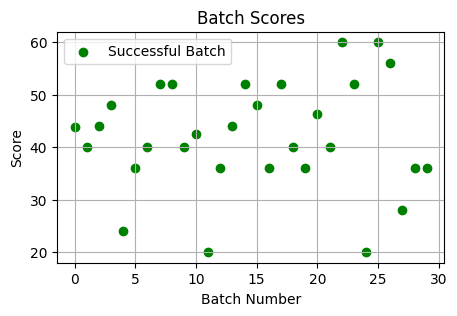

In [7]:
import matplotlib.pyplot as plt

trial_logs = compiled_program.trial_logs

# Extracting trial numbers, scores, and pruning status
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]
pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

# Plot setup
plt.figure(figsize=(5, 3))

# Plotting each point
for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
    if pruned:
        plt.scatter(trial_number, score, color='grey', label='Pruned Batch' if 'Pruned Batch' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(trial_number, score, color='green', label='Successful Batch' if 'Successful Batch' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.title('Batch Scores')
plt.grid(True)
plt.legend()
plt.show()

We can also __visualize the best prompts__ discovered by MIPRO as our trials progress... (though note that score increases are also due to the selected fewshot examples, which are not shown here for conciseness).

In [8]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Baseline program | Score: {best_score}:")
for i,predictor in enumerate(program.predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in compiled_program.trial_logs:
    program_score = compiled_program.trial_logs[trial_num]["score"]
    program_pruned = compiled_program.trial_logs[trial_num]["pruned"]
    if program_score > best_score and not program_pruned and compiled_program.trial_logs[trial_num]["full_eval"]:
        best_score = program_score
        best_program_so_far = compiled_program.trial_logs[trial_num]["program"]
    if trial_num % 5 == 0:
        print(f"Best program after {trial_num} batches | Score: {best_score}:")
        for i,predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
        print()

Baseline program | Score: 0:
Prompt 1 Instruction: Given the fields `context`, `question`, produce the fields `search_query`.
Prompt 2 Instruction: Given the fields `context`, `question`, produce the fields `answer`.
Prompt 3 Instruction: Given a question we are trying to answer and a list of passages, return a comma separated list of the numbers associated with each passage. These numbers should be ordered by helpfulness in answering the question, with most helpful passage number first, and the least helpful last.

----------------
Best program after 0 batches | Score: 43.8:
Prompt 1 Instruction: Given a set of context and question pairs, prompt the model to generate a search query that accurately captures the key information needed to answer the question within the given context.
Prompt 2 Instruction: Given the provided context about the album "Plastic Beach" and the specific question, "Who released the album that 'Stylo' was a single on in the United States?", generate the accurate 

#### 3d] Saving your program for later use

Now that we've gone through all this work of compiling a program it would be a shame to throw it away.  Fortunately we don't have to.  We can save your compiled program to disk with .save()!

This file is also human interpretable, so it's worth taking a look at the optimized program.  You can load it later with .load() on a program with the same modules.

In [9]:
compiled_program.save("compiled_program.dspy")